Here are represented single solution approaches to solving time-cost tradeoff budget problem: classic local search for descrete domain with gradient being Monte Carlo (random), Simulated Annealing and RVNS (Random Variable Neighborhood Search).

In [1]:
graphName = "graphs/testGraph.txt"
costsName = "graphs/testGraphcosts.txt"

In [2]:
from collections import defaultdict

# Nodes in DAG that are represented as (node, [list of ancestor])
def getImmediateAncestors(filename):
    with open(filename, 'r') as file:
        nodes = defaultdict(list)
        
        # Dummy nodes source and super sink that are added to represent start and end of project
        sourceNodes = set()
        superSinkNodes = set()
        removeFromeSource = set()
        removeFromSuperSink = set()
        
        # Necessary representation for networkx to draw graph
        GxNodes = set()
        GxEdges = []
            
        for line in file:
            # from represented direceted edges as (node ancestor) we get all ancestors
            node, ancestor = line.split()
            
            GxEdges.append((node, ancestor))
            
            nodes[node].append(ancestor)
            sourceNodes.add(node)
            superSinkNodes.add(ancestor)
            removeFromeSource.add(ancestor)
            removeFromSuperSink.add(node)
        
        for node in removeFromeSource:
            sourceNodes.discard(node)
        for node in removeFromSuperSink:
            superSinkNodes.discard(node)
            
        nodes['s'] = list(sourceNodes)
        nodes['ss'] = [None]
        for node in superSinkNodes:
            nodes[node].append('ss')
            GxEdges.append((node, 'ss'))
        
        for s in sourceNodes:
            GxEdges.append(('s', s))
        GxNodes = list(sourceNodes)
        
#         for node in nodes:
#             print(node, nodes[node])

        # return values are directed acyclic graph represened as dictionary with nodes and their ancestors
        # and GxNodes, GxEdges which is needed representation of graph for drawing
        return nodes, GxNodes, GxEdges

In [3]:
nodes, GxNodes, GxEdges = getImmediateAncestors(graphName)

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def drawGraph(GxNodes, GxEdges):
    # init empty graph
    Gx = nx.Graph()
    # add starting node
    Gx.add_nodes_from('s')
    # add list of remaining nodes
    Gx.add_nodes_from(GxNodes)
    # add edges
    Gx.add_edges_from(GxEdges)
    nx.draw_networkx(Gx,node_size=900, arrows=True, arrowstyle='-|>')

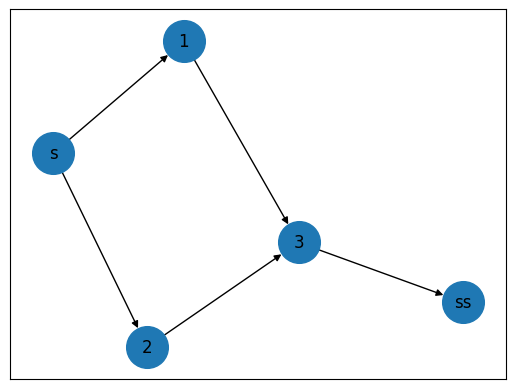

In [5]:
drawGraph(GxNodes, GxEdges)

In [6]:
def getCost(filename):
    
    with open(filename, 'r') as file:
        nodes = defaultdict(list)
        currentNode = -1
        
        for line in file:
            values = line.split()
            if values[0] == 'n':
                currentNode = values[1]
                nodes[currentNode] = []
            for index in range(2, len(values)):
                duration, cost = values[index].split(',')
                duration = int(duration[1:])
                cost = int(cost[:-1])
                nodes[currentNode].append((duration, cost))

        return nodes

In [7]:
costs = getCost(costsName)

In [8]:
def generateSolution(costs):
    solution = [0 for _ in range(len(costs))]
    
    for node in costs:
        if node == 's' or node == 'ss':
            continue
        solution[int(node)] = random.randrange(len(costs[node]))
    
    return solution

In [9]:
def budgetValue(costs, solution, budget):
    cost = 0
    for index in range(1, len(solution)-1):
        cost += costs[str(index)][solution[index]][1]
    return cost

In [10]:
def isFeasible(costs, solution, budget):
    return budgetValue(costs, solution, budget) < budget

In [11]:
import numpy as np

def correctNonFeasable(solution, costs, budget):
    solutionValue = budgetValue(costs, solution, nodes)
    if solutionValue < budget:
        return
    
    difference = budget - solutionValue
    solutionCosts = []
    
    solutionCosts.append(0)
    for i in range(1, len(solution)-1):
        solutionCosts.append(costs[str(i)][solution[i]][1])
    solutionCosts.append(0)
    
    for i in range(1, len(solution)-1):
        argMax = np.argmax(solutionCosts)
        for j in range(len(costs[str(argMax)])):
            if costs[str(argMax)][j][1] < costs[str(argMax)][solution[argMax]][1]:
                solution[argMax] = j
                if budgetValue(costs, solution, nodes) < budget:
                    return
        solutionCosts[argMax] = 0
    else:
        print("Ne moze se popraviti")

In [12]:
def generateFeasibleSolution(costs, budget):
    solution = [0 for _ in range(len(costs))]
    
    for node in costs:
        if node == 's' or node == 'ss':
            continue
        solution[int(node)] = random.randrange(len(costs[node]))
    
    if not isFeasible(costs, solution, budget):
        correctNonFeasable(solution, costs, budget)
    return solution

In [13]:
def getEarliestStartTime(nodes, solution, graph, earliestStartTime):
    if nodes == []:
        return earliestStartTime
    durations = set()
    newNodes = set()
#     print(nodes)
    for node in nodes:
#         print(node)
        if node == 'ss':
            durations.add(0)
            continue
        step = solution[int(node)]
        durations.add(costs[node][step][0])
        for ancestor in graph[node]:
            newNodes.add(ancestor)
    earliestStartTime += max(durations)
    return getEarliestStartTime(list(newNodes), solution, graph, earliestStartTime)

In [14]:
def solutionValue(solution, costs, graph):
    return getEarliestStartTime(graph['s'], solution, graph, 0)

In [15]:
def changeSolution(solution, costs, graph):
#     print("changeSolution", solution)
    changeStep = random.randrange(1, len(solution) - 1)
    step = random.randrange(len(costs[str(changeStep)]))
    if step == solution[changeStep]:
        return changeSolution(solution, costs, graph)
    else:
        oldValue = solution[changeStep]
        solution[changeStep] = step
#         print("changeSolution", solution)
        return (changeStep, oldValue)

In [16]:
import random 

def localSearch(costs, nodes, iters, budget):
    solution = generateFeasibleSolution(costs, budget)
    currValue = solutionValue(solution, costs, nodes)
    bestValue = currValue
    
    for i in range(iters):
        step, oldValue = changeSolution(solution, costs, nodes)
        if not isFeasible(costs, solution, budget):
            solution[step] = oldValue
        else:
            newValue = solutionValue(solution, costs, nodes)
            if newValue < currValue:
                currValue = newValue
                if newValue < bestValue:
                    bestValue = newValue
            else:
                solution[step] = oldValue
    return bestValue, solution, budgetValue(costs, solution, budget)

In [17]:
duration, solution, projectCost = localSearch(costs, nodes, 100, 30)
print(duration, solution, projectCost)

7 [0, 1, 0, 1, 0] 26


In [18]:
def simulatedAnnealing(costs, nodes, iters, budget):
    solution = generateFeasibleSolution(costs, budget)
    currValue = solutionValue(solution, costs, nodes)
    bestValue = currValue
    
    for i in range(1, iters + 1):
        step, oldValue = changeSolution(solution, costs, nodes)
        if not isFeasible(costs, solution, budget):
            solution[step] = oldValue
        else:
            newValue = solutionValue(solution, costs, nodes)
            if newValue < currValue:
                currValue = newValue
                if newValue < bestValue:
                    bestValue = newValue
            else:
                p = 1.0 / i ** 0.5
                q = random.uniform(0, 1)
                if p > q:
                    currValue = newValue
                else:
                    solution[step] = oldValue
    return bestValue, solution, budgetValue(costs, solution, budget)

In [19]:
duration, solution, projectCost  = simulatedAnnealing(costs, nodes, 100, 30)
print(duration, solution, projectCost)

7 [0, 1, 0, 1, 0] 26


In [20]:
def getNeighborSolution(solution, k):
    indices = range(1, len(solution) - 1)
    changeSteps = random.sample(indices, k)
    
    oldValues = []
    
    for index in changeSteps:
        changeStep = random.randrange(1, len(solution) - 1)
        step = random.randrange(len(costs[str(index)]))
        
        oldValues.append(solution[index])
        solution[index] = step
        
    return (changeSteps, oldValues)
        

In [21]:
def restoreOldValue(solution, changeSteps, oldValues):
    for i in range(len(changeSteps)):
        solution[changeSteps[i]] = oldValues[i]
    

In [22]:
MAX_K = 3

In [23]:
def RVNS(costs, nodes, iters, budget, max_k):
    solution = generateFeasibleSolution(costs, budget)
    currValue = solutionValue(solution, costs, nodes)
    bestValue = currValue
    
    for i in range(1, iters + 1):
        k = 0
        while k <= max_k:
            changeSteps, oldValues = getNeighborSolution(solution, k)
            if not isFeasible(costs, solution, budget):
                restoreOldValue(solution, changeSteps, oldValues)
                continue
            newValue = solutionValue(solution, costs, nodes)
            if newValue < currValue:
                currValue = newValue
                if newValue < bestValue:
                    bestValue = newValue
                break
            else:
                k += 1
                restoreOldValue(solution, changeSteps, oldValues)
    return bestValue, solution, budgetValue(costs, solution, budget)     

In [24]:
duration, solution, projectCost = RVNS(costs, nodes, 100, 30, MAX_K)
print(duration, solution, projectCost)

7 [0, 1, 0, 1, 0] 26


In [25]:
import time

def executeAlgorithms(graph, costs, budget, iters):
    
    print("\n\n--------------------------------------- " + str(iters) + " ---------------------------------------\n\n")
    
    start = time.perf_counter()
    duration, solution, projectCost = localSearch(costs, nodes, iters, budget)
    print("Solution: ", solution)
    print("Duration: ", duration)
    print("Cost: ", projectCost)        
    end = time.perf_counter()
    executionTime = end - start
    print("Time needed for Local Search execution: " + str(executionTime))
    
    print()
    
    start = time.perf_counter()
    duration, solution, projectCost = simulatedAnnealing(costs, nodes, iters, budget)
    print("Solution: ", solution)
    print("Duration: ", duration)
    print("Cost: ", projectCost)        
    end = time.perf_counter()
    executionTime = end - start
    print("Time needed for Simulated Annealing execution: " + str(executionTime))
    
    print()
    
    start = time.perf_counter()
    duration, solution, projectCost = RVNS(costs, nodes, iters, budget, MAX_K)
    print("Solution: ", solution)
    print("Duration: ", duration)
    print("Cost: ", projectCost)        
    end = time.perf_counter()
    executionTime = end - start
    print("Time needed for RVNS execution: " + str(executionTime))
    
    print()

In [26]:
executeAlgorithms(nodes, costs, 26, 100)



--------------------------------------- 100 ---------------------------------------


Solution:  [0, 1, 0, 2, 0]
Duration:  9
Cost:  21
Time needed for Local Search execution: 0.00048577900088275783

Solution:  [0, 1, 0, 2, 0]
Duration:  9
Cost:  21
Time needed for Simulated Annealing execution: 0.00046225199912441894

Solution:  [0, 1, 0, 2, 0]
Duration:  9
Cost:  21
Time needed for RVNS execution: 0.008319332999235485





--------------------------------------- 100 ---------------------------------------


Solution:  [0, 0, 0, 0, 0, 1, 0, 3, 2, 1, 1, 0, 0, 3, 2, 1, 0, 0, 1, 0, 3, 0, 1, 2, 0, 1, 1, 2, 0, 0, 0, 1, 1, 2, 0, 2, 0, 1, 0, 1, 0, 2, 0, 2, 0, 2, 0, 1, 0, 1, 0, 0, 1, 0]
Duration:  43
Cost:  2998
Time needed for Local Search execution: 0.01459862800038536

Solution:  [0, 0, 0, 1, 1, 2, 1, 1, 3, 0, 2, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 2, 1, 3, 2, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 1, 3, 0, 1, 2, 2, 1, 2, 1, 0, 2, 0, 0, 1, 1, 0]
Duration:  50
Cost:  2968
Time needed for Simulated Annealing execution: 0.010724743999162456

Solution:  [0, 0, 0, 0, 0, 2, 1, 1, 3, 0, 0, 0, 0, 2, 1, 0, 1, 0, 1, 0, 2, 0, 0, 1, 1, 1, 3, 2, 0, 0, 0, 1, 1, 2, 0, 3, 0, 0, 0, 2, 1, 0, 0, 1, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0]
Duration:  49
Cost:  2990
Time needed for RVNS execution: 0.06581667700083926



--------------------------------------- 1000 ---------------------------------------


Solution:  [0, 0, 0, 1, 0, 2, 1, 3, 1, 1

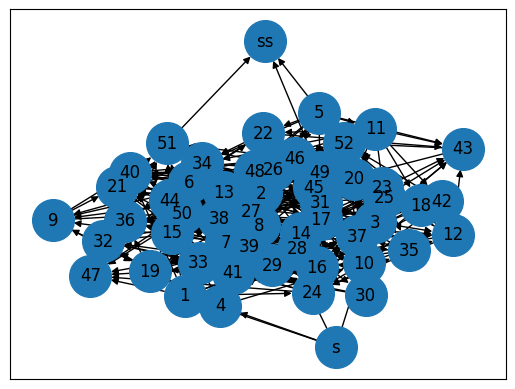

In [27]:
graphName = "graphs/graph5.txt"
costsName = "graphs/graph5costs.txt"
nodes, GxNodes, GxEdges = getImmediateAncestors(graphName)
costs = getCost(costsName)
budget = 3000

for iters in [100, 1000, 10000]:
    executeAlgorithms(nodes, costs, budget, iters)

drawGraph(GxNodes, GxEdges)


Solution:  [0, 1, 0, 1, 0]
Duration:  7
Cost:  26
Time needed for Local Search execution: 0.0012700820007012226

Solution:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 2, 1, 1, 2, 2, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0]
Duration:  26
Cost:  8037
Time needed for Local Search execution: 0.0206847529989318

Solution:  [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 3, 2, 0, 1, 2, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 2, 0]
Duration:  24
Cost:  2809
Time needed for Local Search execution: 0.015879301998211304

Solution:  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 2, 1, 2, 0, 1, 0, 0, 0, 2, 0, 1, 0, 0, 1, 2, 1, 1, 0, 2, 2, 0, 1, 1, 0, 2, 2, 0, 1, 1, 0]
Duration:  28
Cost:  2646
Time needed for Local Search execution: 0.019025284997042036

Solution:  [0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 1, 2, 1, 0, 2, 0, 0, 2, 0, 1, 0, 0, 1, 0, 2, 0, 3, 0, 2, 3, 1, 2, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 3, 0, 2, 0, 3, 2, 0, 0, 1, 3, 2, 0, 0, 3, 0, 0, 0, 0, 3, 1, 0, 1, 0

Solution:  [0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0]
Duration:  22
Cost:  3528
Time needed for Local Search execution: 0.4871132009975554

Solution:  [0, 0, 1, 2, 1, 0, 0, 0, 1, 0, 1, 2, 1, 0, 1, 0, 0, 2, 0, 0, 0, 1, 1, 0, 2, 2, 1, 0, 2, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 2, 0, 2, 0, 0, 1, 1, 0, 0, 2, 0, 0, 0, 1, 0, 1, 0, 0, 0, 2, 2, 0, 1, 0, 2, 1, 2, 0, 0, 0, 0, 1, 0, 2, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]
Duration:  53
Cost:  5846
Time needed for Local Search execution: 2.577047987997503

Solution:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 1, 2, 0, 0, 0, 0, 2, 0, 0, 1, 2, 0, 1, 0, 0, 0, 0, 2, 1, 1, 0, 1, 0, 0, 1, 3, 1, 2, 1, 3, 2, 2, 0, 1, 1, 0, 0, 0, 0, 0]
Duration:  47
Cost:  3499
Time needed for Local Search execution: 0.8283211660018424

Solution:  [0, 3, 0, 3, 2, 1, 1, 2, 2, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 2, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,

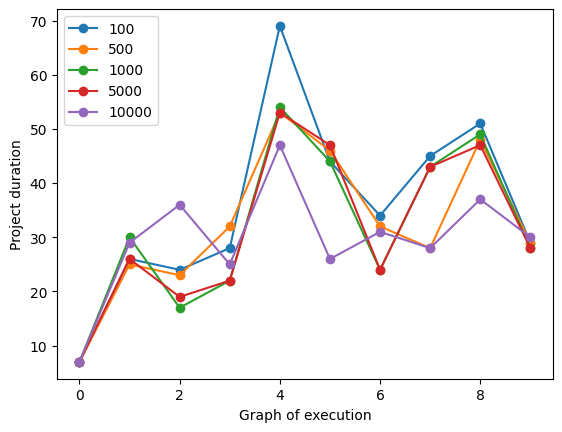

In [28]:
import time

graphNames = ["testGraph", "graph1","graph2", "graph3", "graph4", "graph5", "graph6", "graph7", "graph8", "graph10"]
graphBudget = [30, 10000, 3600, 4000, 8750, 5200, 7100, 7100, 2500, 3300]

minimalDurations = []

for iters in [100, 500, 1000, 5000, 10000]:
    for i in range(len(graphNames)):
        nodes, GxNodes, GxEdges = getImmediateAncestors("graphs/" + graphNames[i] + ".txt") 
        costs = getCost("graphs/" + graphNames[i] + "costs" + ".txt")
    
        start = time.perf_counter()
        duration, solution, projectCost = localSearch(costs, nodes, iters, graphBudget[i])
        print("Solution: ", solution)
        print("Duration: ", duration)
        print("Cost: ", projectCost)        
        end = time.perf_counter()
        executionTime = end - start
        print("Time needed for Local Search execution: " + str(executionTime))
        minimalDurations.append(duration)

        print()
    plt.plot(range(len(graphNames)), minimalDurations, '-o', label=iters)
    plt.legend(loc='upper left')
    minimalDurations = []
    
plt.xlabel("Graph of execution")
plt.ylabel("Project duration")
plt.show()

Solution:  [0, 1, 0, 1, 0]
Duration:  7
Cost:  26
Time needed for Local Search execution: 0.0012361590015643742

Solution:  [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 2, 0, 2, 2, 1, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
Duration:  25
Cost:  7926
Time needed for Local Search execution: 0.020205471002554987

Solution:  [0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 2, 1, 3, 3, 1, 2, 0, 1, 0, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Duration:  26
Cost:  2654
Time needed for Local Search execution: 0.008900864999304758

Solution:  [0, 2, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 2, 0, 0, 0, 2, 2, 1, 1, 0, 2, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]
Duration:  29
Cost:  2985
Time needed for Local Search execution: 0.009425288000784349

Solution:  [0, 3, 0, 2, 0, 0, 0, 0, 1, 0, 3, 2, 1, 0, 2, 0, 1, 2, 0, 2, 0, 2, 3, 0, 3, 2, 2, 0, 1, 2, 1, 2, 1, 1, 0, 0, 1, 0, 1, 2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 3, 1, 0, 2, 0, 1, 2, 1, 3, 0,

Solution:  [0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]
Duration:  13
Cost:  3422
Time needed for Local Search execution: 0.4715814179980953

Solution:  [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Duration:  34
Cost:  7697
Time needed for Local Search execution: 2.5446912860024895

Solution:  [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0]
Duration:  26
Cost:  4233
Time needed for Local Search execution: 0.82277755999894

Solution:  [0, 1, 0, 0, 0, 0, 1, 1, 2, 2, 1, 0, 0, 2, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 2, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 

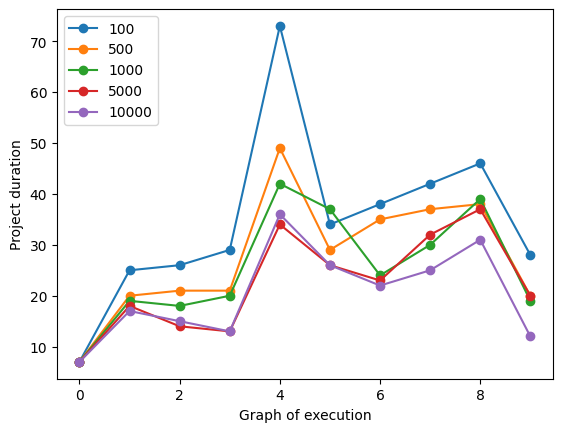

In [29]:
import time

graphNames = ["testGraph", "graph1","graph2", "graph3", "graph4", "graph5", "graph6", "graph7", "graph8", "graph10"]
graphBudget = [30, 10000, 3600, 4000, 8750, 5200, 7100, 7100, 2500, 3300]

minimalDurations = []

for iters in [100, 500, 1000, 5000, 10000]:
    for i in range(len(graphNames)):
        nodes, GxNodes, GxEdges = getImmediateAncestors("graphs/" + graphNames[i] + ".txt") 
        costs = getCost("graphs/" + graphNames[i] + "costs" + ".txt")
    
        start = time.perf_counter()
        duration, solution, projectCost = simulatedAnnealing(costs, nodes, iters, graphBudget[i])
        print("Solution: ", solution)
        print("Duration: ", duration)
        print("Cost: ", projectCost)        
        end = time.perf_counter()
        executionTime = end - start
        print("Time needed for Local Search execution: " + str(executionTime))
        minimalDurations.append(duration)

        print()
    plt.plot(range(len(graphNames)), minimalDurations, '-o', label=iters)
    plt.legend(loc='upper left')
    minimalDurations = []
    
plt.xlabel("Graph of execution")
plt.ylabel("Project duration")
plt.show()

Solution:  [0, 1, 0, 1, 0]
Duration:  7
Cost:  26
Time needed for Local Search execution: 0.009074305002286565

Solution:  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Duration:  17
Cost:  9031
Time needed for Local Search execution: 0.08111071399980574

Solution:  [0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0]
Duration:  20
Cost:  3177
Time needed for Local Search execution: 0.06169479500022135

Solution:  [0, 0, 0, 1, 1, 1, 1, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0]
Duration:  23
Cost:  2841
Time needed for Local Search execution: 0.07530584000051022

Solution:  [0, 2, 1, 3, 0, 0, 0, 1, 1, 0, 2, 3, 1, 0, 2, 0, 1, 0, 0, 2, 0, 3, 0, 0, 0, 1, 0, 0, 1, 2, 0, 2, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 2, 0, 1, 1, 0, 2, 1, 1, 

Solution:  [0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 1, 1, 0, 1, 2, 0, 2, 0, 1, 1, 2, 0, 1, 1, 0]
Duration:  28
Cost:  2846
Time needed for Local Search execution: 1.8829154250015563

Solution:  [0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 2, 0, 0, 0, 0, 1, 0, 1, 0, 0, 2, 0, 0, 1, 0, 1, 1, 2, 0, 1, 0, 0, 0, 2, 1, 2, 0, 0, 2, 0, 2, 0, 1, 2, 2, 1, 0, 1, 1, 1, 0, 2, 0, 0, 0, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Duration:  49
Cost:  6465
Time needed for Local Search execution: 9.751034573000652

Solution:  [0, 0, 0, 0, 0, 1, 1, 2, 1, 0, 2, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Duration:  22
Cost:  4562
Time needed for Local Search execution: 3.224517046000983

Solution:  [0, 0, 1, 1, 1, 0, 0, 1, 0, 2, 1, 1, 1, 0, 1, 0, 0, 1, 2, 1, 0, 0, 0, 2, 1, 0, 0, 2, 1, 0, 2, 1, 1, 2, 1, 2, 2, 1, 2, 0, 1, 0, 2, 0, 1, 0, 

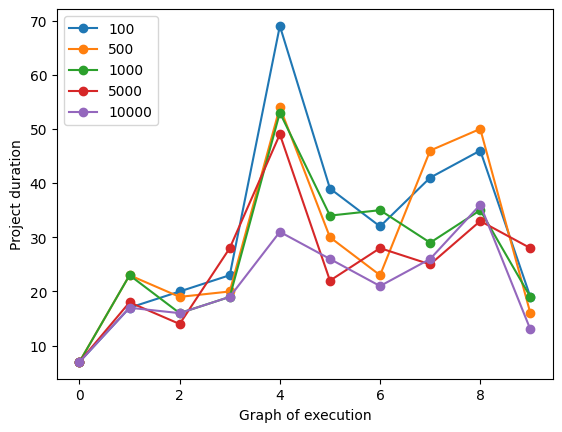

In [30]:
import time

graphNames = ["testGraph", "graph1","graph2", "graph3", "graph4", "graph5", "graph6", "graph7", "graph8", "graph10"]
graphBudget = [30, 10000, 3600, 4000, 8750, 5200, 7100, 7100, 2500, 3300]

minimalDurations = []

for iters in [100, 500, 1000, 5000, 10000]:
    for i in range(len(graphNames)):
        nodes, GxNodes, GxEdges = getImmediateAncestors("graphs/" + graphNames[i] + ".txt") 
        costs = getCost("graphs/" + graphNames[i] + "costs" + ".txt")
    
        start = time.perf_counter()
        duration, solution, projectCost = RVNS(costs, nodes, iters, graphBudget[i], 3)
        print("Solution: ", solution)
        print("Duration: ", duration)
        print("Cost: ", projectCost)        
        end = time.perf_counter()
        executionTime = end - start
        print("Time needed for Local Search execution: " + str(executionTime))
        minimalDurations.append(duration)

        print()
    plt.plot(range(len(graphNames)), minimalDurations, '-o', label=iters)
    plt.legend(loc='upper left')
    minimalDurations = []
    
plt.xlabel("Graph of execution")
plt.ylabel("Project duration")
plt.show()